# PoseNet for Self-Localization Task on Apolloscape Dataset

PoseNet implementation on Apolloscape dataset. It's a part of the localization methods exploration for Apolloscape Self-Localization Challenge on [ECCV 2018](http://apolloscape.auto/ECCV/challenge.html)

In [1]:
# Load all dependency
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params, quaternion_angular_error

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

`APOLLO_PATH` is a location with unpacked Apolloscape datasets, e.g. `$APOLLO_PATH/road02_seg` or `$APOLLO_PATH/zpark`. Download data from [Apolloscape page](http://apolloscape.auto/scene.html) and unpack it to the `APOLLO_PATH` dir. Let's we've symbolically linked `APOLLO_PATH` folder to `./data/apolloscape`.

In [2]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])


train_record = None # 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = None # 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)


print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=40, shuffle=True) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: True
    Normalize Poses: True
    Length: 1121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: None
    Train: False
    Normalize Poses: True
    Length: 378 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



## Draw Train and Val datasets

Visualize poses from `train` and `val` datasets to check that it covers all val path.

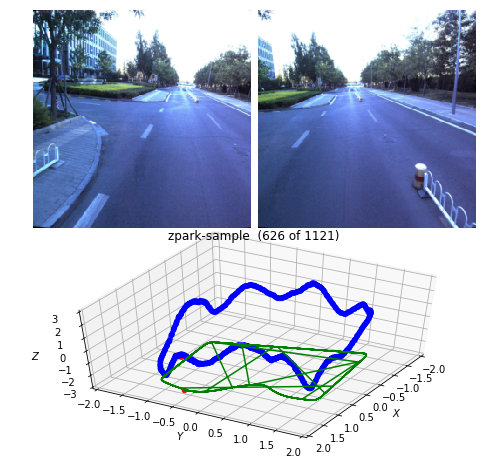

In [ ]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()


## Device set up

Determine the primary device and use it for training/validation.

In [ ]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

## Train and Validate Functions

Train function runs one epoch through training data.

In [ ]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True,
          poses_mean=None, poses_std=None):
    
    # switch model to training
    model.train()
    
    losses = AverageMeter()
    
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # move data to cpu & numpy
        bp = [x.detach().cpu().numpy() for x in batch_poses]
        outp = [x.detach().cpu().numpy() for x in out]
        gt_poses = np.vstack((gt_poses, *bp))
        pred_poses = np.vstack((pred_poses, *outp))
        
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))

            
    # un-normalize translation
    unnorm = (poses_mean is not None) and (poses_std is not None)
    if unnorm:
        gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
        pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
    q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#     if unnorm:
#         print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
#     print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
#     print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

            
    if print_sum:
        print('Ep: [{}/{}]\tTrain Loss: {:.3f}\tTe: {:.3f}\tRe: {:.3f}\t Et: {:.2f}s'.format(
            epoch, max_epoch - 1, losses.avg, np.mean(t_loss), np.mean(q_loss),
            (time.time() - epoch_time)))
        
#     return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}\tEpoch time: {:.3f}'.format(epoch, losses.avg,
                                                                               (time.time() - epoch_time)))
        
#     return losses.avg


## Create Model, Criterion and Optimizer

PoseNet implementation is a ResNet based feature extractor that ends with custom fully-connected regressor layers for translation (3D pose) and rotation (quaternion).

In [ ]:
# Create pretrained feature extractor
# feature_extractor = models.resnet18(pretrained=True)
feature_extractor = models.resnet34(pretrained=False)
# feature_extractor = models.resnet50(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = PoseNet(feature_extractor, num_features=num_features)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion(stereo=True, beta=200.0)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=6e-7, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

It helps to continue training later or just use it for the inference.

In [ ]:
# Restore from checkpoint
# checkpoint_file = '_checkpoints/20180809_131703_apollo_zpark_all_w34_2048L2_e5403.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


## Run Training

Training loop that runs for `n_epochs` with validation every `val_freq` epochs.

In [8]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
n_epochs = start_epoch + 600

print('Training ...')
val_freq = 50
for e in range(start_epoch, n_epochs):
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0,
         poses_mean=train_dataset.poses_mean, poses_std=train_dataset.poses_std)
    if e % val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=0)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Ep: [4803/5402]	Train Loss: 0.993	Te: 11.080	Re: 0.463	 Et: 21.68s
Ep: [4804/5402]	Train Loss: 0.867	Te: 9.487	Re: 0.434	 Et: 21.92s
Ep: [4805/5402]	Train Loss: 1.055	Te: 10.779	Re: 0.503	 Et: 21.83s
Ep: [4806/5402]	Train Loss: 1.168	Te: 10.450	Re: 0.616	 Et: 21.84s
Ep: [4807/5402]	Train Loss: 1.059	Te: 10.138	Re: 0.564	 Et: 21.79s
Ep: [4808/5402]	Train Loss: 0.824	Te: 10.323	Re: 0.381	 Et: 21.94s
Ep: [4809/5402]	Train Loss: 0.883	Te: 10.387	Re: 0.373	 Et: 21.84s
Ep: [4810/5402]	Train Loss: 0.883	Te: 11.129	Re: 0.399	 Et: 21.98s
Ep: [4811/5402]	Train Loss: 0.981	Te: 10.344	Re: 0.436	 Et: 21.87s
Ep: [4812/5402]	Train Loss: 0.930	Te: 9.939	Re: 0.497	 Et: 21.68s
Ep: [4813/5402]	Train Loss: 0.944	Te: 11.023	Re: 0.409	 Et: 21.68s
Ep: [4814/5402]	Train Loss: 1.167	Te: 10.957	Re: 0.538	 Et: 21.54s
Ep: [4815/5402]	Train Loss: 1.095	Te: 11.797	Re: 0.569	 Et: 21.80s
Ep: [4821/5402]	Train Loss: 0.877	Te: 9.521	Re: 0.425	 Et: 21.70s
Ep: [4822/5402]	Train Loss: 0.841	Te: 10.865	Re: 0.388	 Et: 21.81

Ep: [4930/5402]	Train Loss: 0.725	Te: 9.734	Re: 0.339	 Et: 21.54s
Ep: [4931/5402]	Train Loss: 0.846	Te: 10.631	Re: 0.428	 Et: 21.67s
Ep: [4932/5402]	Train Loss: 0.969	Te: 9.689	Re: 0.431	 Et: 21.68s
Ep: [4933/5402]	Train Loss: 1.065	Te: 9.041	Re: 0.514	 Et: 21.61s
Ep: [4934/5402]	Train Loss: 0.913	Te: 11.031	Re: 0.425	 Et: 21.88s
Ep: [4935/5402]	Train Loss: 0.850	Te: 10.427	Re: 0.416	 Et: 21.78s
Ep: [4936/5402]	Train Loss: 0.807	Te: 11.615	Re: 0.366	 Et: 21.81s
Ep: [4937/5402]	Train Loss: 0.787	Te: 11.260	Re: 0.382	 Et: 21.83s
Ep: [4938/5402]	Train Loss: 1.017	Te: 9.952	Re: 0.472	 Et: 21.70s
Ep: [4939/5402]	Train Loss: 0.832	Te: 11.417	Re: 0.388	 Et: 21.72s
Ep: [4940/5402]	Train Loss: 0.911	Te: 11.003	Re: 0.427	 Et: 21.75s
Ep: [4941/5402]	Train Loss: 1.023	Te: 12.435	Re: 0.470	 Et: 21.81s
Ep: [4942/5402]	Train Loss: 0.859	Te: 10.314	Re: 0.409	 Et: 21.80s
Ep: [4943/5402]	Train Loss: 0.839	Te: 9.425	Re: 0.421	 Et: 21.83s
Ep: [4944/5402]	Train Loss: 0.793	Te: 12.426	Re: 0.375	 Et: 21.74s


Ep: [5056/5402]	Train Loss: 0.766	Te: 9.722	Re: 0.361	 Et: 21.46s
Ep: [5057/5402]	Train Loss: 1.093	Te: 8.855	Re: 0.554	 Et: 21.17s
Ep: [5058/5402]	Train Loss: 1.118	Te: 9.831	Re: 0.533	 Et: 21.64s
Ep: [5059/5402]	Train Loss: 1.146	Te: 9.239	Re: 0.507	 Et: 21.78s
Ep: [5060/5402]	Train Loss: 0.964	Te: 10.083	Re: 0.461	 Et: 21.88s
Ep: [5061/5402]	Train Loss: 0.850	Te: 8.688	Re: 0.409	 Et: 21.67s
Ep: [5062/5402]	Train Loss: 0.795	Te: 9.355	Re: 0.380	 Et: 21.66s
Ep: [5063/5402]	Train Loss: 0.662	Te: 9.291	Re: 0.297	 Et: 21.72s
Ep: [5064/5402]	Train Loss: 0.917	Te: 9.875	Re: 0.437	 Et: 21.79s
Ep: [5065/5402]	Train Loss: 0.892	Te: 10.288	Re: 0.436	 Et: 21.81s
Ep: [5066/5402]	Train Loss: 0.813	Te: 10.342	Re: 0.390	 Et: 21.73s
Ep: [5067/5402]	Train Loss: 0.874	Te: 9.627	Re: 0.439	 Et: 21.70s
Ep: [5068/5402]	Train Loss: 0.831	Te: 8.893	Re: 0.406	 Et: 21.64s
Ep: [5069/5402]	Train Loss: 0.877	Te: 11.387	Re: 0.356	 Et: 21.88s
Ep: [5070/5402]	Train Loss: 0.727	Te: 11.894	Re: 0.342	 Et: 21.74s
Ep: [

Ep: [5178/5402]	Train Loss: 0.985	Te: 9.722	Re: 0.468	 Et: 21.79s
Ep: [5179/5402]	Train Loss: 0.852	Te: 9.637	Re: 0.428	 Et: 21.89s
Ep: [5180/5402]	Train Loss: 0.828	Te: 9.364	Re: 0.397	 Et: 21.83s
Ep: [5181/5402]	Train Loss: 0.915	Te: 10.066	Re: 0.418	 Et: 21.68s
Ep: [5182/5402]	Train Loss: 0.834	Te: 9.393	Re: 0.386	 Et: 21.86s
Ep: [5183/5402]	Train Loss: 0.754	Te: 8.967	Re: 0.347	 Et: 21.87s
Ep: [5184/5402]	Train Loss: 0.936	Te: 9.375	Re: 0.470	 Et: 21.77s
Ep: [5185/5402]	Train Loss: 0.972	Te: 8.718	Re: 0.495	 Et: 21.91s
Ep: [5186/5402]	Train Loss: 0.915	Te: 9.243	Re: 0.449	 Et: 21.90s
Ep: [5187/5402]	Train Loss: 0.946	Te: 11.546	Re: 0.450	 Et: 21.81s
Ep: [5188/5402]	Train Loss: 0.853	Te: 10.413	Re: 0.426	 Et: 21.70s
Ep: [5189/5402]	Train Loss: 0.912	Te: 9.697	Re: 0.416	 Et: 21.80s
Ep: [5190/5402]	Train Loss: 0.967	Te: 10.579	Re: 0.452	 Et: 21.85s
Ep: [5191/5402]	Train Loss: 0.971	Te: 11.181	Re: 0.477	 Et: 21.88s
Ep: [5192/5402]	Train Loss: 0.871	Te: 10.841	Re: 0.393	 Et: 21.77s
Ep: 

Epoch: [5300]	Validation Loss: 4.663	Epoch time: 5.637
Ep: [5301/5402]	Train Loss: 0.925	Te: 8.245	Re: 0.438	 Et: 21.86s
Ep: [5302/5402]	Train Loss: 0.891	Te: 8.538	Re: 0.408	 Et: 21.97s
Ep: [5303/5402]	Train Loss: 0.899	Te: 9.622	Re: 0.448	 Et: 21.81s
Ep: [5304/5402]	Train Loss: 0.912	Te: 9.380	Re: 0.457	 Et: 21.77s
Ep: [5305/5402]	Train Loss: 0.763	Te: 9.082	Re: 0.367	 Et: 21.88s
Ep: [5306/5402]	Train Loss: 0.834	Te: 8.483	Re: 0.398	 Et: 22.11s
Ep: [5307/5402]	Train Loss: 0.914	Te: 10.607	Re: 0.447	 Et: 21.97s
Ep: [5308/5402]	Train Loss: 1.112	Te: 8.922	Re: 0.546	 Et: 21.78s
Ep: [5309/5402]	Train Loss: 0.946	Te: 9.479	Re: 0.489	 Et: 21.82s
Ep: [5310/5402]	Train Loss: 0.941	Te: 9.661	Re: 0.497	 Et: 21.75s
Ep: [5311/5402]	Train Loss: 0.880	Te: 9.186	Re: 0.441	 Et: 21.84s
Ep: [5312/5402]	Train Loss: 0.929	Te: 8.929	Re: 0.446	 Et: 21.75s
Ep: [5313/5402]	Train Loss: 1.363	Te: 8.895	Re: 0.723	 Et: 21.82s
Ep: [5314/5402]	Train Loss: 0.814	Te: 8.986	Re: 0.413	 Et: 21.47s
Ep: [5315/5402]	Trai

## Test Model Error on Validation and Train Datasets

Calculate translation and rotation error of the predicted poses on train and validation datasets.

In [ ]:
def model_results_pred_gt(model, dataloader, poses_mean, poses_std):
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]

        out = model(batch_images)
        
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        # move data to cpu & numpy
        batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
        out = [x.detach().cpu().numpy() for x in out]

        gt_poses = np.vstack((gt_poses, *batch_poses))
        pred_poses = np.vstack((pred_poses, *out))
        
    # un-normalize translation
    gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
    pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean
    
    return pred_poses, gt_poses


# Get mean and std from dataset
poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std



print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses


print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, val_dataloader, poses_mean, poses_std)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses




=== Test Training Dataset ======


### Visualize Prediction and Ground Truth Poses

Draw ground truth in `blue` and predictions in `red` colors.

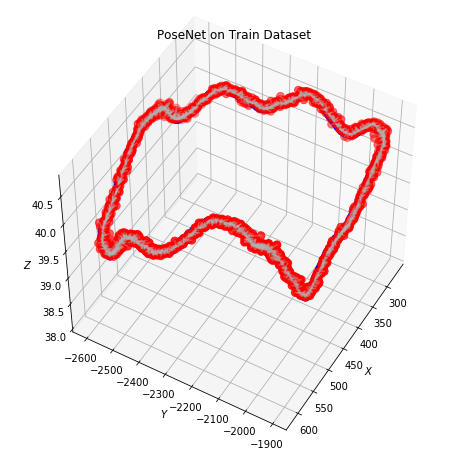

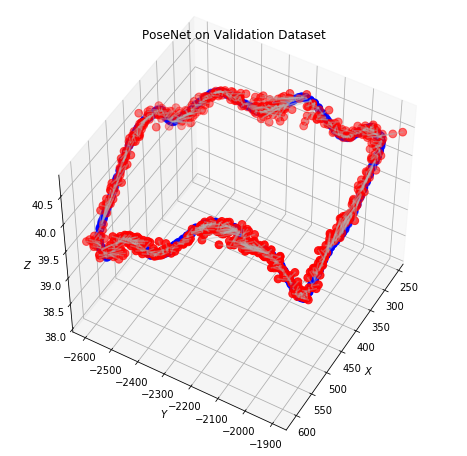

In [10]:
def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


# Draw predicted vs ground truth poses
draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('PoseNet on Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('PoseNet on Validation Dataset')
plt.show()



## Save Model Checkpoint

In [11]:
# Save checkpoint
# n_epochs = 4203
save_checkpoint(model, optimizer, 'apollo_zpark_all_w34_2048L2', n_epochs)
    

'_checkpoints/20180809_131703_apollo_zpark_all_w34_2048L2_e5403.pth.tar'